# Overview
This jupyter notebook covers the following contents:
1. Default configuration in LIBERO
2. Basic information about available LIBERO benchmarks
   - Get a dictionary of mapping from benchmark name to benchmark class
   - Check the integrity of benchmarks
   - Check the integrity of init files
   - Visualize all the init states of a task
   - Download datasets
   - Get information about a demonstration file and replay a trajectory


In [9]:
from libero.libero import benchmark, get_libero_path
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import imageio
import os

In [10]:
def cammat2o3d(cam_mat, width, height):
    cx = cam_mat[0,2]
    fx = cam_mat[0,0]
    cy = cam_mat[1,2]
    fy = cam_mat[1,1]

    return o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

def verticalFlip(img):
    return np.flip(img, axis=0)

def get_camera_position(sim, camera_name):
    camera_id = sim.model.camera_name2id(camera_name)
    camera_pos = sim.model.body_pos[camera_id]
    return camera_pos

def visualize_rgb_depth(rgb_img, depth_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(verticalFlip(rgb_img))
    ax[0].set_title("RGB Image")
    ax[0].axis('off')  # Hide the axis
    cax = ax[1].imshow(verticalFlip(depth_img), cmap='tab20b')
    ax[1].set_title("Depth Image")
    ax[1].axis('off')  # Hide the axis
    fig.colorbar(cax, ax=ax[1])
    plt.show()

def create_video(images: list, name: str = "recording", show: bool = False):
    video_writer = imageio.get_writer("output.mp4", fps=60)
    for image in images:
        video_writer.append_data(image[::-1])
    video_writer.close()

    if show:
        HTML("""
            <video width="640" height="480" controls>
                <source src="output.mp4" type="video/mp4">
            </video>
            <script>
                var video = document.getElementsByTagName('video')[0];
                video.playbackRate = 2.0; // Increase the playback speed to 2x
                </script>    
        """)

In [11]:

bddl_files_default_path = get_libero_path("bddl_files")

datasets = "libero_spatial" # "all", "libero_goal", "libero_spatial", "libero_object", "libero_100"
benchmark_dict = benchmark.get_benchmark_dict()
benchmark_instance = benchmark_dict[datasets]()
num_tasks = benchmark_instance.get_num_tasks()
demo_files = [os.path.join('/home/ahad/programming/ATM/datasets', benchmark_instance.get_task_demonstration(i)) for i in range(num_tasks)]

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [12]:
import h5py
from pathlib import Path
import json
from libero.libero.envs import OffScreenRenderEnv


demo_file = Path(demo_files[0])
bddl_path = str(Path(bddl_files_default_path) / demo_file.parent.stem / (demo_file.stem[:-5] + '.bddl'))

with h5py.File(demo_file, "r") as f:
    env_metadata = json.loads(f["data"].attrs["env_args"])
    data = f['data']
    demo = data['demo_0']
    states = demo['states'][()]

env_kwargs = env_metadata['env_kwargs']
env_kwargs['controller'] = env_kwargs.pop('controller_configs')['type']
env_kwargs['camera_depths'] = True
env_kwargs['bddl_file_name'] = bddl_path

camera_heights, camera_widths = env_kwargs['camera_heights'], env_kwargs['camera_widths']

kwargs = dict(bddl_file_name=bddl_path, camera_heights=camera_heights, camera_widths=camera_widths, camera_depths=True)
env = OffScreenRenderEnv(**kwargs)
env.reset()

for state in states:
    obs = env.set_init_state(state)

camera_names = env_kwargs['camera_names']
camera_name = camera_names[1]

rgb_img, depth_img = obs[camera_name + "_image"], obs[camera_name + "_depth"]

In [13]:
from robosuite.utils.camera_utils import get_camera_intrinsic_matrix

camera_height, camera_width = env_kwargs['camera_heights'], env_kwargs['camera_widths']
camera_names = env_kwargs['camera_names']
camera_name = camera_names[1]

rgb_img, depth_img = obs[camera_name + "_image"], obs[camera_name + "_depth"]


img_height, img_width = rgb_img.shape[:-1]
rgb_img, depth_img = o3d.cuda.pybind.geometry.Image(rgb_img), o3d.cuda.pybind.geometry.Image(depth_img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_img, depth_img)

intrinsic_matrix = get_camera_intrinsic_matrix(env.sim, camera_name, camera_heights, camera_widths)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(camera_heights, camera_widths, intrinsic_matrix)
)

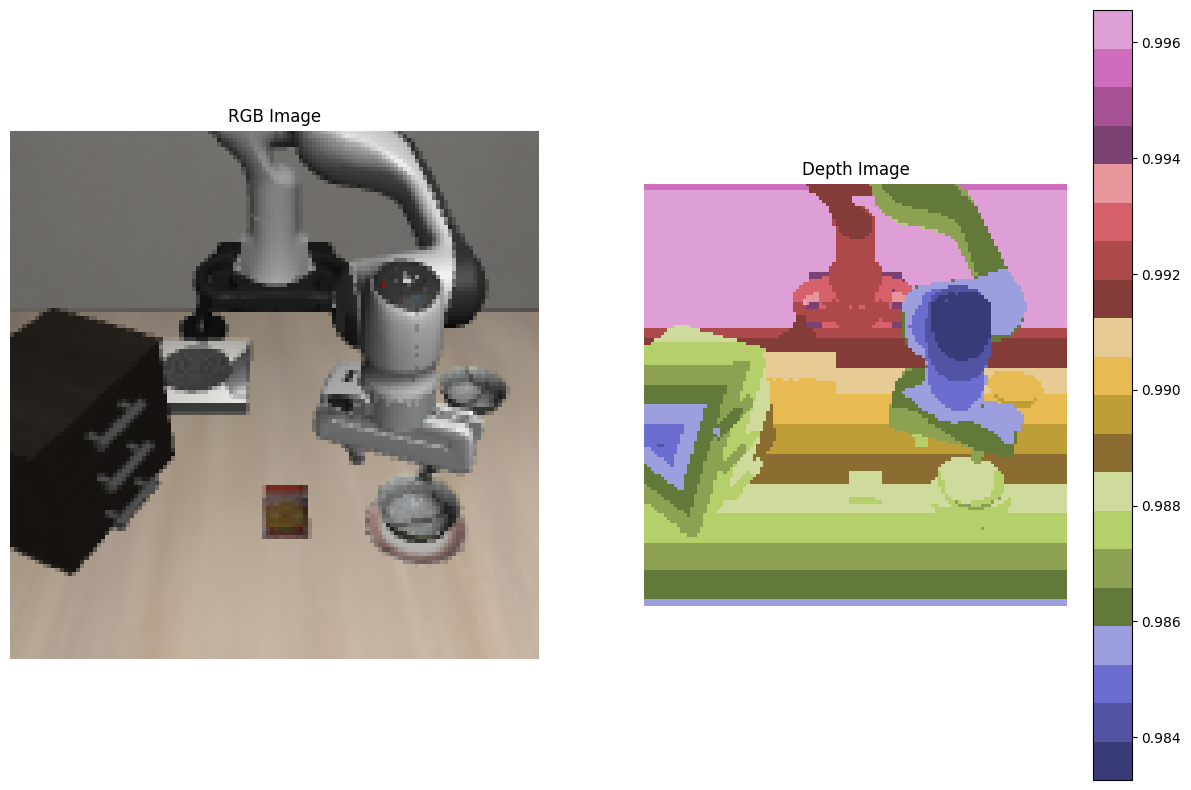

In [15]:
visualize_rgb_depth(rgb_img, depth_img)